In [60]:
import numpy as np
import pandas as pd
from xml.dom import minidom

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
def row_generator(datapath, ddipath):
    ''' Maps each line of the data file to the variables and values
        it represents '''
    # get mapping
    pmap = pos_map(ddipath)
    f = open(datapath, 'r')
    for line in f:
        # apply mapping
        row = {}
        for var in pmap.keys():
            start = pmap[var]['spos']
            end = pmap[var]['epos']
            dec = pmap[var]['dec']
            if dec:
                mid = end - dec
                row[var] = line[start:mid] + '.' + line[mid:end]
            else:
                row[var] = line[start : end]
        # yield mapping
        yield row


def pos_map(ddipath):
    ''' Returns a dictionary mapping the variable names to their positions
        and decimal places in the data file '''
    m = minidom.parse(ddipath)    
    vmap = {}
    varNodes = m.getElementsByTagName('var')
    for varNode in varNodes:
        locNode = varNode.getElementsByTagName('location')[0]
        name = varNode.attributes.getNamedItem('ID').value
        vmap[name] = {
            'spos' : int(locNode.attributes.getNamedItem('StartPos').value) - 1,
            'epos' : int(locNode.attributes.getNamedItem('EndPos').value),
            'dec' : int(varNode.attributes.getNamedItem('dcml').value)
            }
    return vmap

In [4]:
rows = row_generator(
    datapath = "ipums.dat", 
    ddipath = "ipums.xml"
)

In [5]:
df = pd.DataFrame(list(rows))

In [6]:
alameda = df[(df.COUNTY == '0010')]
alameda = alameda.replace(r'^\s*$', np.nan, regex=True)
alameda = alameda.apply(pd.to_numeric)

## Group Quarters vs. Households

First, we want to be sure that we're only taking data from households. The PUMS data distinguishes between 'households' and 'group quarters': in our case, we're only interested in the former, because variables that are necessary for our calculations are not included with the latter.

According to the data dictionary, entries are households when `GQ` is either 1 or 2 (and potentially 5, though I am unsure).

So, let's first extract the households.

In [18]:
households = alameda[(alameda.GQ == 1) | (alameda.GQ == 2)]
household_reps = households[households.PERNUM == 1]

## Low-income households

Low-income households in Alameda county scale according to the number of people in the household.

The IPUMS data has samplings across households and includes the information about the people in each household. Thus, we'll extract the first person from each household as a representative.

To determine the low-income households, we'll extract the number of persons per household and compare to the thresholds.

In [45]:
def extend_low_income(thres, upper_N=25):
    extras = (np.arange(9, upper_N) - 8) * thres[3] * 0.08 + thres[-1]
    thres = np.append(thres, extras)
    return thres

In [102]:
households.head()

,CIDATAPLN,CIDIAL,CIHAND,CIHISPEED,CILAPTOP,CINETHH,CIOTHCOMP,CIOTHSVC,CISAT,CISMRTPHN,CITABLET,COUNTY,DATANUM,GQ,HHINCOME,HHWT,NUMPREC,PERNUM,PERWT,PUMA,SERIAL,STATEFIP,YEAR
18,0,0,2.0,0,2,3,2,0,0,NaN,NaN,10,1,1,9400,97.0,2,1,97.0,102,66410,6,2013
19,0,0,2.0,0,2,3,2,0,0,NaN,NaN,10,1,1,9400,97.0,2,2,80.0,102,66410,6,2013
117,0,0,1.0,0,1,2,2,0,0,NaN,NaN,10,1,1,73500,96.0,2,1,97.0,107,66447,6,2013
118,0,0,1.0,0,1,2,2,0,0,NaN,NaN,10,1,1,73500,96.0,2,2,95.0,107,66447,6,2013
160,1,2,1.0,11,1,1,2,2,2,NaN,NaN,10,1,1,144000,58.0,3,1,59.0,108,66464,6,2013


In [84]:
puma_labels = [
    r'\textbf{Berkeley \& Albany}',
    r'\textbf{Northwest Oakland \& Emeryville}',
    r'\textbf{East Oakland (Hills) \& Piedmont}',
    r'\textbf{Oakland (South Central)}',
    r'\textbf{San Leandro, Alameda, \& Southwest Oakland}',
    r'\textbf{Castro Valley, San Lorenzo, \& Ashland}',
    r'\textbf{Hayward City}',
    r'\textbf{Union City, Newark, and West Fremont}',
    r'\textbf{East Fremont}',
    r'\textbf{Livermore, Pleasanton, \& Dublin}'
]

In [46]:
alameda_low_income = np.array([62750, 71700, 80650, 89600, 96800, 103950, 111150, 118300])
alameda_low_income = extend_low_income(alameda_low_income)

In [47]:
def extract_low_income_households(household_reps, year):
    # extract survey data for given year
    alameda_by_year = alameda[alameda.YEAR == year]
    
    # extract household representatives
    household_reps = alameda_by_year[alameda_by_year.PERNUM == 1]
    
    # extract households that are low-income
    low_income_table = household_reps.loc[
        household_reps.HHINCOME < alameda_low_income[household_reps.NUMPREC - 1]
    ]
    
    # extract households that are not low-income
    non_low_income_table = household_reps.loc[
        household_reps.HHINCOME >= alameda_low_income[household_reps.NUMPREC - 1]
    ]
    
    return low_income_table, non_low_income_table

In [56]:
def access_to_internet(years):
    internet_li = np.zeros((len(years), 10))
    internet_nli = np.zeros((len(years), 10))
    for idx, year in enumerate(years):
        low_income, non_low_income = extract_low_income_households(household_reps, year=year)
        
        li_removed_NA = low_income[low_income.CINETHH != 0]
        nli_removed_NA = non_low_income[non_low_income.CINETHH != 0]
        
        total_li = li_removed_NA.groupby('PUMA').sum().HHWT
        internet_subscription_li = li_removed_NA[li_removed_NA.CINETHH == 1].groupby('PUMA').sum().HHWT
        
        total_nli = nli_removed_NA.groupby('PUMA').sum().HHWT
        internet_subscription_nli = nli_removed_NA[nli_removed_NA.CINETHH == 1].groupby('PUMA').sum().HHWT
        
        internet_li[idx] = 1 - internet_subscription_li/total_li
        internet_nli[idx] = 1 - internet_subscription_nli/total_nli
        
    return internet_li, internet_nli

In [58]:
internet_li, internet_nli = access_to_internet([2013, 2014, 2015, 2016])

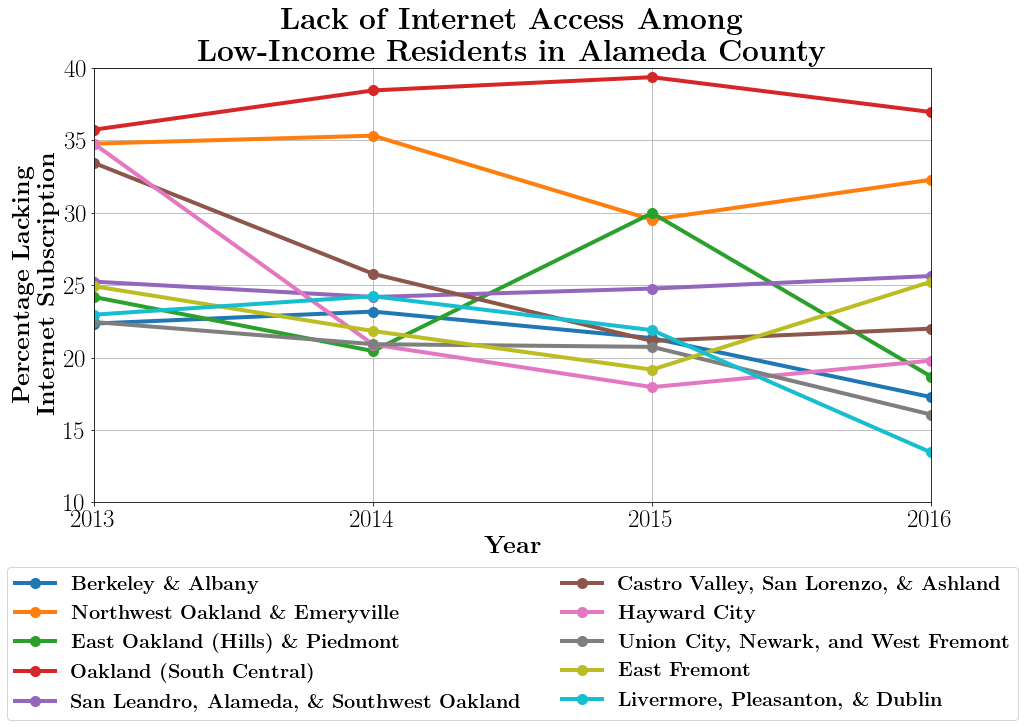

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * internet_li[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Internet Subscription}', fontsize=25)
ax.set_title(r'\textbf{Lack of Internet Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)

plt.savefig('li_internet.pdf', bbox_inches='tight')

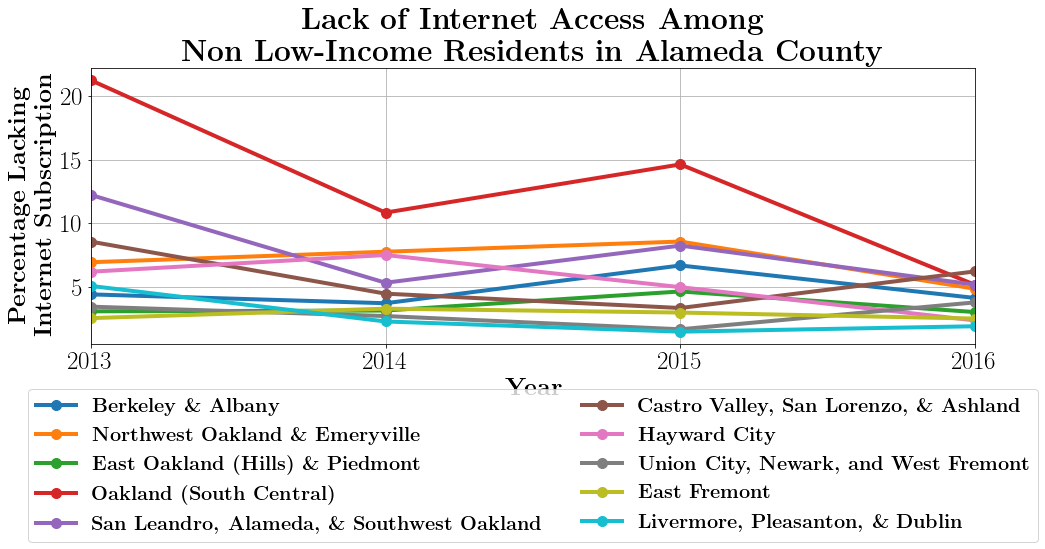

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * internet_nli[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Internet Subscription}', fontsize=25)
ax.set_title(r'\textbf{Lack of Internet Access Among}' '\n' r'\textbf{Non Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('nli_internet.pdf', bbox_inches='tight')

In [112]:
def access_to_laptop(years):
    laptop_li = np.zeros((len(years), 10))
    laptop_nli = np.zeros((len(years), 10))
    for idx, year in enumerate(years):
        low_income, non_low_income = extract_low_income_households(household_reps, year=year)
        
        li_removed_NA = low_income[low_income.CILAPTOP != 0]
        nli_removed_NA = non_low_income[non_low_income.CILAPTOP != 0]
        
        total_li = li_removed_NA.groupby('PUMA').sum().HHWT
        owns_laptop_li = li_removed_NA[li_removed_NA.CILAPTOP == 1].groupby('PUMA').sum().HHWT
        
        total_nli = nli_removed_NA.groupby('PUMA').sum().HHWT
        owns_laptop_nli = nli_removed_NA[nli_removed_NA.CILAPTOP == 1].groupby('PUMA').sum().HHWT
        
        laptop_li[idx] = 1 - owns_laptop_li/total_li
        laptop_nli[idx] = 1 - owns_laptop_nli/total_nli
        
    return laptop_li, laptop_nli

In [113]:
laptop_li, laptop_nli = access_to_laptop([2013, 2014, 2015, 2016])

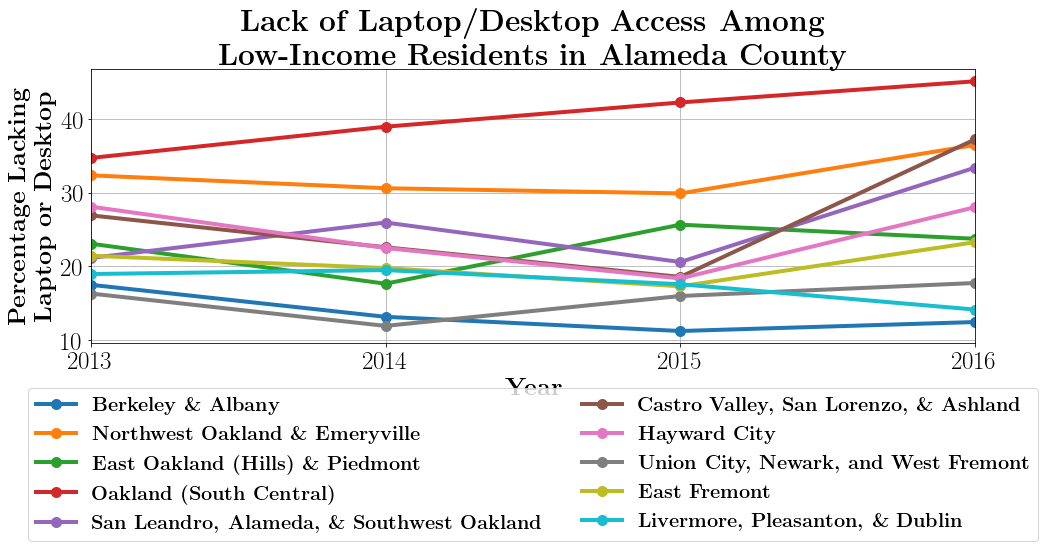

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * laptop_li[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
#ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Laptop or Desktop}', fontsize=25)
ax.set_title(r'\textbf{Lack of Laptop/Desktop Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('li_desktop.pdf', bbox_inches='tight')

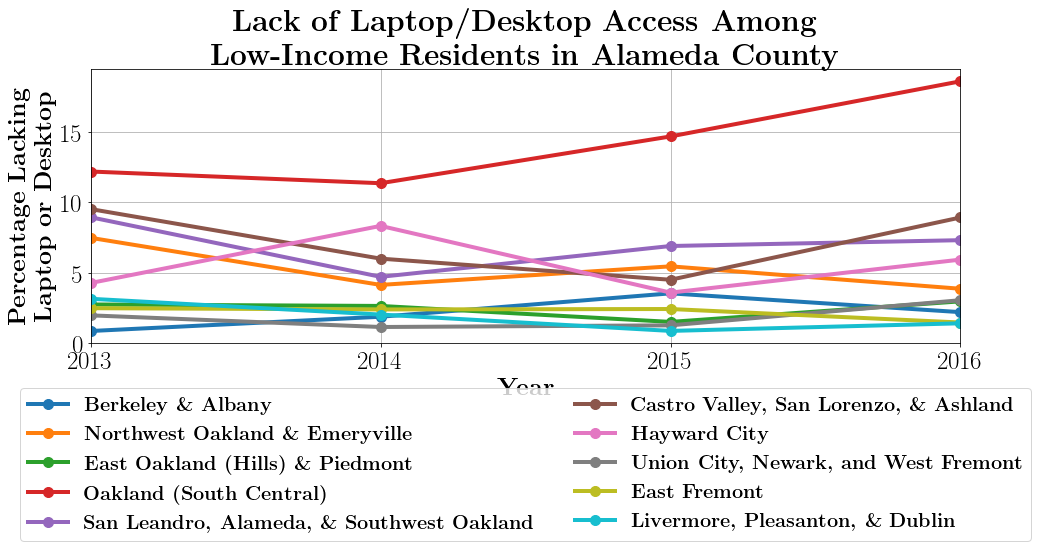

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * laptop_nli[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
#ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Laptop or Desktop}', fontsize=25)
ax.set_title(r'\textbf{Lack of Laptop/Desktop Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('nli_desktop.pdf', bbox_inches='tight')